In [1]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.ao.quantization as quant

# Data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Utilities
import time
import os
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


In [2]:
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
EXP_DIR = Path("../experiments")

device = "cpu"  # PTQ is evaluated on CPU


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_set = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=False,
    transform=transform
)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [4]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

float_model = FFN().to(device)
float_model.load_state_dict(torch.load(MODEL_DIR / "ffn_baseline.pth"))
float_model.eval()


FFN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [5]:
class QuantFFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = quant.QuantStub()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.dequant = quant.DeQuantStub()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.quant(x)
        x = self.net(x)
        x = self.dequant(x)
        return x

quant_model = QuantFFN()
quant_model.load_state_dict(float_model.state_dict())
quant_model.eval()


QuantFFN(
  (quant): QuantStub()
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (dequant): DeQuantStub()
)

In [6]:
quant_model.qconfig = quant.get_default_qconfig("fbgemm")

quant.prepare(quant_model, inplace=True)

# Calibration (observer statistics)
with torch.no_grad():
    for x, _ in test_loader:
        quant_model(x)


/tmp/ipykernel_368537/4278481950.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quant.prepare(quant_model, inplace=True)
/home/rebu/Desktop/Projects/Interns/Icog/training-tasks/LLM-Optimization/venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:1039: UserWarning: Please use quant_min and quant_max to specify the range for observers.                 

In [7]:
quant.convert(quant_model, inplace=True)
print("PTQ conversion complete.")


PTQ conversion complete.


/tmp/ipykernel_368537/10867775.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quant.convert(quant_model, inplace=True)


In [8]:
float_path = MODEL_DIR / "ffn_baseline.pth"
int8_path = MODEL_DIR / "ffn_ptq_int8.pth"

torch.save(float_model.state_dict(), float_path)
torch.save(quant_model.state_dict(), int8_path)

float_size = os.path.getsize(float_path) / 1e6
int8_size = os.path.getsize(int8_path) / 1e6

print(f"FP32 size: {float_size:.2f} MB")
print(f"INT8 size: {int8_size:.2f} MB")


FP32 size: 0.94 MB
INT8 size: 0.25 MB


In [9]:
def evaluate(model):
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

fp32_acc = evaluate(float_model)
int8_acc = evaluate(quant_model)

print("FP32 Accuracy:", fp32_acc)
print("INT8 Accuracy:", int8_acc)


FP32 Accuracy: 0.9784
INT8 Accuracy: 0.978


In [10]:
def measure_latency(model, runs=200):
    x, _ = next(iter(test_loader))
    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            model(x)
    return (time.time() - start) / runs

fp32_latency = measure_latency(float_model)
int8_latency = measure_latency(quant_model)

print("FP32 latency:", fp32_latency)
print("INT8 latency:", int8_latency)


FP32 latency: 0.0010068380832672118
INT8 latency: 0.0006133770942687988


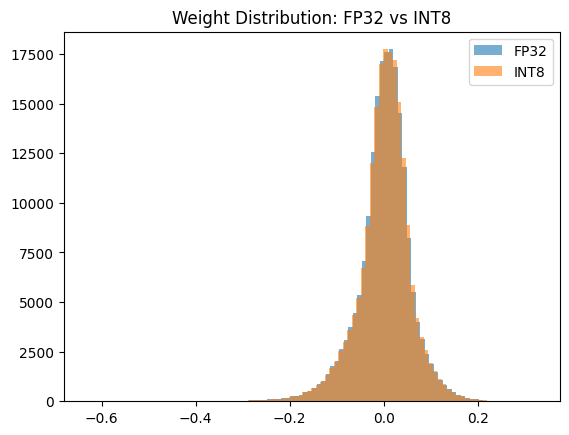

In [11]:
fp32_w = float_model.net[0].weight.detach().cpu().numpy().flatten()
int8_w = quant_model.net[0].weight().dequantize().cpu().numpy().flatten()

plt.hist(fp32_w, bins=100, alpha=0.6, label="FP32")
plt.hist(int8_w, bins=100, alpha=0.6, label="INT8")
plt.legend()
plt.title("Weight Distribution: FP32 vs INT8")
plt.show()


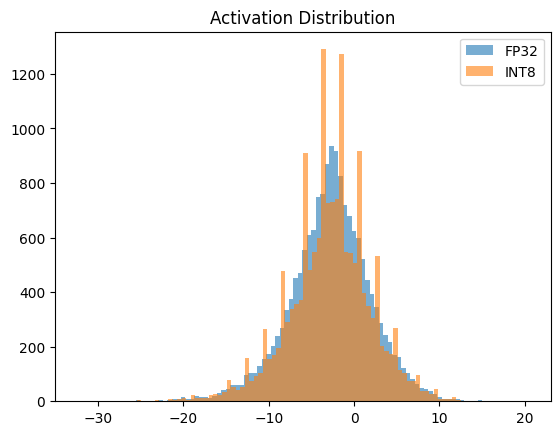

In [12]:
acts_fp32, acts_int8 = [], []

def hook_fp32(_, __, output):
    acts_fp32.append(output.detach().cpu().numpy())

def hook_int8(_, __, output):
    acts_int8.append(output.dequantize().cpu().numpy())

h1 = float_model.net[0].register_forward_hook(hook_fp32)
h2 = quant_model.net[0].register_forward_hook(hook_int8)

x, _ = next(iter(test_loader))
float_model(x)
quant_model(x)

h1.remove()
h2.remove()

plt.hist(np.concatenate(acts_fp32).flatten(), bins=100, alpha=0.6, label="FP32")
plt.hist(np.concatenate(acts_int8).flatten(), bins=100, alpha=0.6, label="INT8")
plt.legend()
plt.title("Activation Distribution")
plt.show()


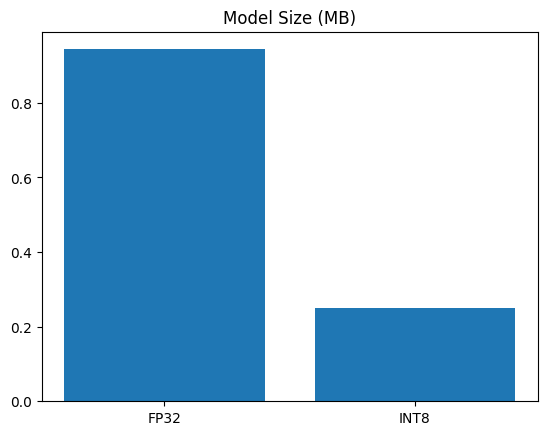

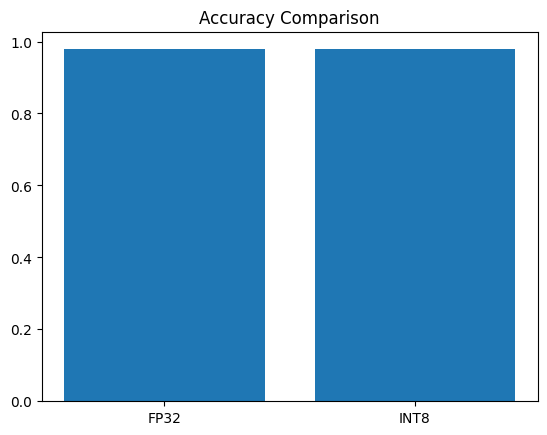

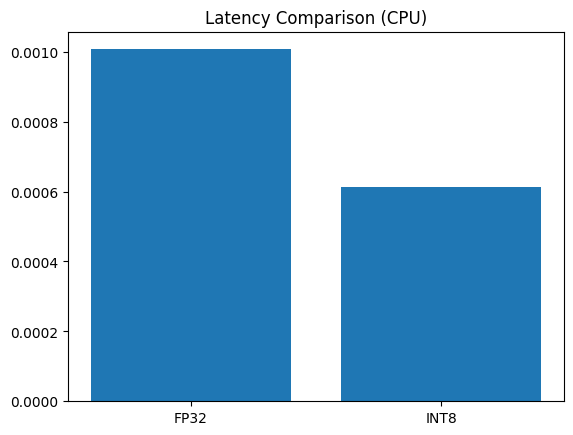

In [13]:
labels = ["FP32", "INT8"]

plt.bar(labels, [float_size, int8_size])
plt.title("Model Size (MB)")
plt.show()

plt.bar(labels, [fp32_acc, int8_acc])
plt.title("Accuracy Comparison")
plt.show()

plt.bar(labels, [fp32_latency, int8_latency])
plt.title("Latency Comparison (CPU)")
plt.show()


In [14]:
csv_path = EXP_DIR / "results.csv"

header = ["model","test_accuracy","train_accuracy","Loss","Size(M)","Latency(s)"]
row_fp32 = ["FFN_FP32", fp32_acc, "NA", "NA", float_size, fp32_latency]
row_int8 = ["FFN_PTQ_INT8", int8_acc, "NA", "NA", int8_size, int8_latency]

write_header = not csv_path.exists()

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(header)
    writer.writerow(row_fp32)
    writer.writerow(row_int8)

print("Metrics saved to results.csv")


Metrics saved to results.csv
